# Redes Neuronales Artificiales


Fuente: https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python.html
El ámbito de las redes neuronales y su hermano mayor, el deep learning, es complejo y amplio. Durante los últimos años, el interés y la aplicación de este tipo de modelos han experimentado tal expansión que se ha convertido en una disciplina por sí misma. Si bien entender bien sus fundamentos requiere de una cantidad notable de tiempo y práctica, esto no significa que se necesiten adquirir todos ellos para empezar a sacarles partido; del mismo modo que no es necesario conocer el funcionamiento de todos los componentes de un smart phone (procesador, antena, circuitos...) para utilizarlo de forma productiva (hacer fotos, mandar email, navegar por internet...). En este documento se presenta una introducción, más intuitiva que rigurosa, sobre los modelos de redes neuronales y de cómo crearlos con python.

En el ecosistema de python, existen múltiples librerías que permiten crear modelos basados en redes neuronales. Conviene diferenciar entre dos casos de uso ya que, dependiendo de estos, son más adecuadas unas librerías u otras:

Modelos de redes simples (multi-perceptrón): estos modelos se caracterizan por tener arquitecturas relativamente sencillas por lo que los requerimientos computacionales no son elevados y no es necesario el uso el uso de GPUs. Dentro de este grupo destacan las implementaciones de Scikit-learn y H2O)

Deep learning: son modelos más complejos (redes convolucionales, redes recurrentes, LSTM...) cuyos requerimientos computacionales hacen necesario el uso de GPUs. Para este tipo de modelos se tiene que recurrir a frameworks especializados para como Tensorflow-Keras o Pytorch.

Los ejemplos de este documento se corresponden con el primer caso de uso, por lo que se utiliza la librería Scikit-learn para crear los modelos. 

Para crear modelos basado en redes neuronales con scikit-learn, se utilizan las clases sklearn.neural_network.MLPRegressor para regresión y sklearn.neural_network.MLPClassifier para clasificación.

Son muchos los argumentos que controlan el comportamiento de este tipo de modelos. Afortunadamente, los responsables de su implementación han establecido valores por defecto que suelen funcionar adecuadamente en muchos escenarios. A continuación, se muestran los más influyentes:

hidden_layer_sizes: número y tamaño de las capas ocultas. Por ejemplo, (100) para una única capa oculta con 100 neuronas, y (16, 16) para dos capas ocultas de 16 neuronas de cada una. El valor por defecto es (100,).

activation: función de activación de las capas ocultas. Puede ser: {'identity', 'logistic', 'tanh', 'relu'}. La misma función de activación se aplica a todas las capas ocultas, no se permiten distintas. El valor por defecto es 'relu'.

solver: el algoritmo de optimización utilizado para aprender los pesos y bias de la red. Puede ser: {'lbfgs', 'sgd', 'dam'}. Por defecto se utiliza 'adam', que es el que mejores resultados suele dar para conjuntos de datos con miles de observaciones. Para sets de datos pequeños, 'lbfgs' converge más rápido y puede conseguir mejores resultados.

alpha: regularización L2 (weight decay). El valor por defecto es 0.0001.

batch_size: tamaño de batch utilizado en los solvers estocásticos ('sgd' y 'dam'). Este parámetro se ignora si el solver es 'lbfgs'. Por defecto se utiliza min(200, n_samples).

learning_rate: estrategia para modificar el learning rate durante el entrenamiento. Solo se utiliza cuando solver='sgd'. Puede ser:

'constant': se utiliza el valor especificado en el argumento learning_rate_init durante todo el proceso de entrenamiento.

'invscaling': se reduce progresivamente el learning rate en cada iteración t utilizando una función exponecial effective_learning_rate = learning_rate_init / pow(t, power_t).

adaptive: mantiene constante el valor especificado en el argumento learning_rate_init siempre y cuando el modelo siga mejorando (reducción de la función de coste). Si entre dos épocas consecutivas el modelo no mejora un mínimo definido en el argumento tol, el learning rate se divide por 5.

learning_rate_init: valor inicial de learning rate. Solo se utiliza cuando el solver es 'sgd' o 'adam'. Por defecto el valor es 0.001.

power_t: exponent eutilizado para reducir el learning rate cuando learning_rate='invscaling'. Por defecto se emplea el valor 0.5. Solo se utiliza este argumento cuando  solver='sgd'.

max_iter: número máximo de iteraciones de entrenamiento. Para los solvers estocásticos ('sgd' y 'adam') este valor se corresponde con el número de épocas (cuantas veces participa en el entrenamiento cada observación). Se emplean por defecto 200.

shuffle: si se mezclan aleatoriamente las observaciones en cada iteración. Por defecto es True.

random_state: semilla utilizada para todos los pasos del entrenaiento que requieren de valores aleatorios (inicialización depesos, splits, bias).

tolfloat: valor de tolerancia utilizado en la optimización. Si la función de coste no mejora durante n_iter_no_change iteraciones consecutivas un mínimo de tolfloat, el entrenamiento finaliza. Por defecto se emplea 1e-4.

early_stopping: detener el entrenamiento cuando la métrica de validación no mejora. Automáticamente, se separa un porcentaje de validation_fraction del conjunto de entrenamiento que se utiliza como conjunto de validación. Si durante más de n_iter_no_change iteraciones (épocas), la métrica de validación no mejora un mínimo de tol, el entrenamiento termina. Solo se aplica si solver es 'sgd' o 'adam'.

validation_fraction: fracción de datos del conjunto de entrenamiento utilizados como conjunto de validación para el early stopping. Por defecto se utiliza 0.1.

n_iter_no_change: número de épocas consecutivas sin mejora que desencadena el early stopping. Por defecto se emplean 10.
Puede encontrarse una descripción más detallada sobre cómo emplear las muchas funcionalidades que ofrece esta librería en el artículo Machine learning con Python y Scikit-learn. 

# Ejemplo

En este primer ejemplo se muestra cómo, dependiendo de la arquitectura (capas ocultas y tamaño de las mismas), un modelo basado en redes neuronales puede aprender funciones no lineales con gran facilidad. Para evitar problemas de overfitting, es importante identificar la combinación de hiperparámetros que consigue un equilibrio adecuado en el aprendizaje. Se trata de un ejemplo muy sencillo, cuyo objetivo es que el lector se familiarice con flexibilidad que tienen este tipo de modelos y en cómo realizar una búsqueda de hiperparámetros mediante grid search y validación cruzada. 

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Datos

Se simulan observaciones en dos dimensiones, pertenecientes a tres grupos, cuya separación no es perfecta.

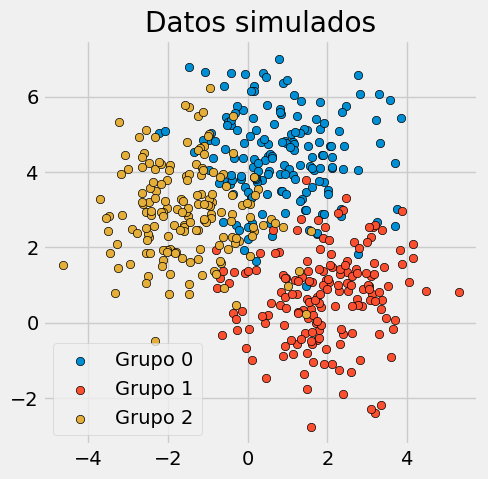

In [2]:
# Datos simulados
# ==============================================================================
X, y = make_blobs(
        n_samples    = 500, 
        n_features   = 2, 
        centers      = 3, 
        cluster_std  = 1.2, 
        shuffle      = True, 
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax.set_title('Datos simulados')
ax.legend();

# Arquitectura de la red
Se procede a crear 4 modelos en orden creciente de complejidad (número de neuronas y capas), para comprobar cómo la arquitectura de la red afecta a su capacidad de aprendizaje. 

In [3]:
# Modelos
# ==============================================================================
modelo_1 = MLPClassifier(
                hidden_layer_sizes=(5),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_2 = MLPClassifier(
                hidden_layer_sizes=(10),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_3 = MLPClassifier(
                hidden_layer_sizes=(20, 20),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_4 = MLPClassifier(
                hidden_layer_sizes=(50, 50, 50),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_1.fit(X=X, y=y)
modelo_2.fit(X=X, y=y)
modelo_3.fit(X=X, y=y)
modelo_4.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
              max_iter=5000, random_state=123, solver='lbfgs')

# Arquitectura de la red
Se procede a crear 4 modelos en orden creciente de complejidad (número de neuronas y capas), para comprobar cómo la arquitectura de la red afecta a su capacidad de aprendizaje. 

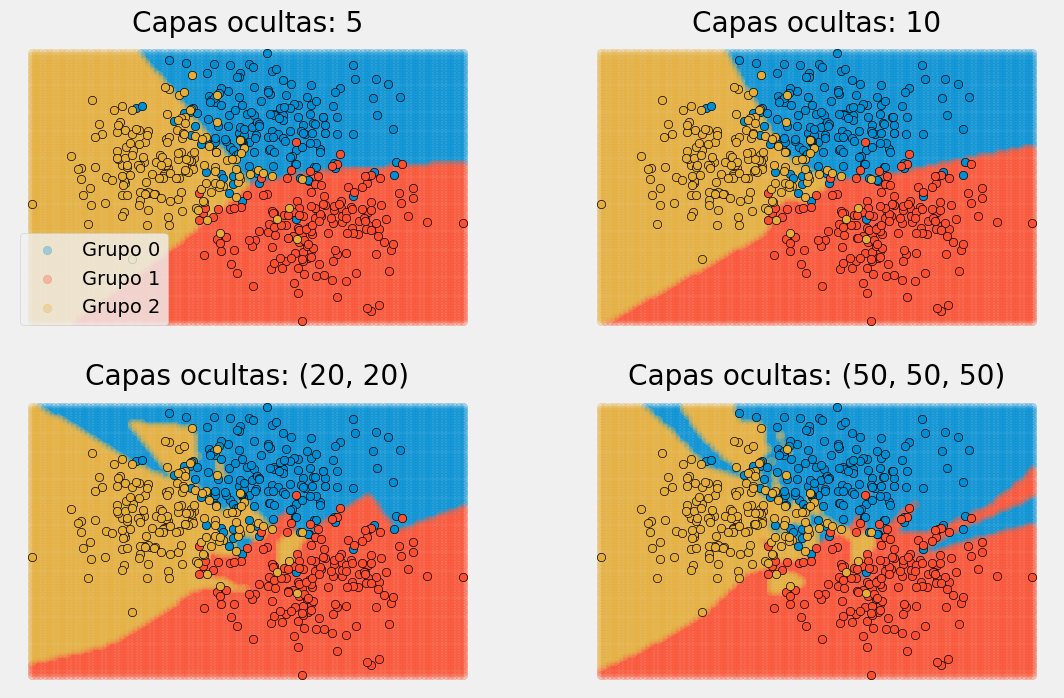

In [4]:
# Gráfico de predicciones
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

for i, modelo in enumerate([modelo_1, modelo_2, modelo_3, modelo_4]):
    
    predicciones = modelo.predict(X_grid)
    
    for j in np.unique(predicciones):
        axs[i].scatter(
            x = X_grid[predicciones == j, 0],
            y = X_grid[predicciones == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            #marker = 'o',
            alpha = 0.3,
            label= f"Grupo {j}"
        )

    for j in np.unique(y):
        axs[i].scatter(
            x = X[y == j, 0],
            y = X[y == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            marker    = 'o',
            edgecolor = 'black'
        )
        
    axs[i].set_title(f"Capas ocultas: {modelo.hidden_layer_sizes}")
    axs[i].axis('off')
axs[0].legend();

Puede observarse como, a medida que aumenta la complejidad de la red (más neuronas y más capas), las fronteras de decisión se adaptan más y más a los datos de entrenamiento. 

# Optimización de Hiperparámetros

En este apartado, se muestra cómo afectan al aprendizaje algunos de los hiperparámetros más influyentes. Como los 2 predictores tienen la misma escala, no es estrictamente necesarios aplicarles una normalización previo entrenamiento.

In [5]:
# Número de neuronas
# ==============================================================================
param_grid = {'hidden_layer_sizes':[1, 5, 10, 15, 25, 50]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        learning_rate_init=0.01,
                        solver = 'lbfgs',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

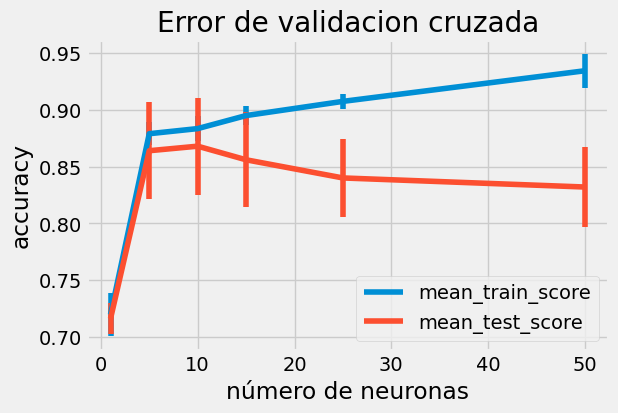

In [6]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('accuracy')
ax.set_xlabel('número de neuronas')
ax.set_title('Error de validacion cruzada');

In [7]:
# learning rate
# ==============================================================================
param_grid = {'learning_rate_init':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        hidden_layer_sizes=(10),
                        solver = 'adam',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

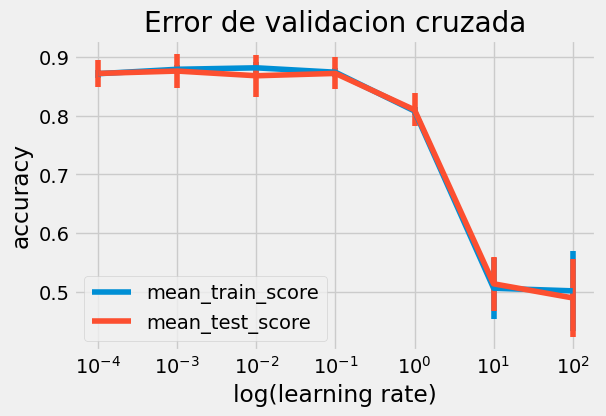

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_learning_rate_init', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_learning_rate_init', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_xscale('log')
ax.set_xlabel('log(learning rate)')
ax.set_ylabel('accuracy')
ax.set_title('Error de validacion cruzada');

Si bien los dos ejemplos anteriores sirven para tener una idea intuitiva de cómo afecta cada hiperparámetro, no es posible optimizarlos de forma individual, ya que el impacto final que tiene cada uno depende de qué valor tomen los demás. La búsqueda de hiperparámetros debe hacerse en conjunto. 


Dado el elevado número de hiperparámetros que tiene los modelos de redes neuronales, la combinación de posibles configuraciones es muy elevada. Esto hace que la búsqueda de hiperparámetros por grid search cartesiano (todas las combinaciones) sea poco práctica. En su lugar, suele emplearse random grid search, que hace una búsqueda de combinaciones aleatorias. Para más información sobre esta y otras estrategias de búsqueda consultar Hiperparámetros (tuning)).

In [9]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init': [0.001, 0.01, 0.1],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 2000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/Users/hugomeza/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
46,0.01,10,100.0,0.871895,0.044519,0.873973,0.021077
30,0.01,10,10.0,0.869911,0.034787,0.874980,0.018839
49,0.1,10,100.0,0.869899,0.042016,0.873973,0.021077
41,0.001,10,10.0,0.867915,0.034652,0.877974,0.023667
11,0.001,10,1.0,0.867891,0.050026,0.888976,0.021049
34,0.1,"(10, 10)",10.0,0.865919,0.037716,0.877977,0.022883
28,0.1,10,1.0,0.865895,0.050566,0.886980,0.024267
4,0.01,"(20, 20)",10.0,0.863923,0.038326,0.880977,0.024650
7,0.01,"(10, 10)",10.0,0.863923,0.035070,0.876976,0.022578
21,0.1,"(20, 20)",10.0,0.863923,0.035070,0.880980,0.024272


La combinación de hiperparámetros que mejores resultados consigue es:

In [10]:
modelo = grid.best_estimator_
modelo

MLPClassifier(alpha=100.0, hidden_layer_sizes=10, learning_rate_init=0.01,
              max_iter=2000, solver='lbfgs')

Una vez entrenado el modelo, al tratarse de solo dos predictores, puede mostrarse gráficamente las regiones de clasificación aprendidas.

In [11]:
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])
predicciones = modelo.predict(X_grid)

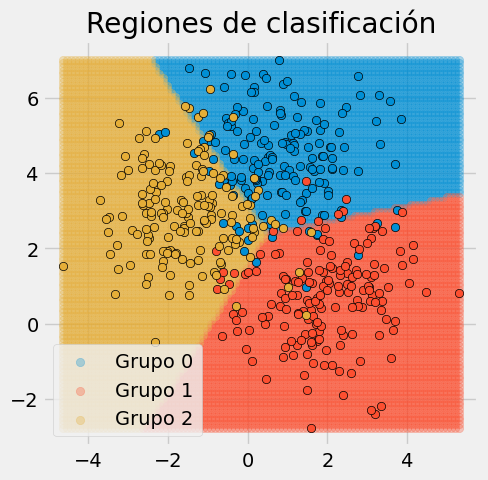

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in np.unique(predicciones):
    ax.scatter(
        x = X_grid[predicciones == i, 0],
        y = X_grid[predicciones == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        #marker = 'o',
        alpha = 0.3,
        label= f"Grupo {i}"
    )

for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black'
    )
    

ax.set_title('Regiones de clasificación')
ax.legend();